In [1]:
import sys
sys.path.append('../data')

import feature_engineering as fe
from clean_data import get_ferien, merge_corona_intensity, get_semesterferien, get_feiertage

import pandas as pd
import numpy as np
import requests
from datetime import datetime
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

/Users/danielzellner/Documents/Studium/Bachelorthesis/venv_global/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/danielzellner/Documents/Studium/Bachelorthesis/src/raw_github_data/2023-01.csv')
df

,Datetime,100035541 (Neutor),101035541 (Neutor stadteinwärts),102035541 (Neutor stadtauswärts),100035541-status,101035541-status,102035541-status
0,2023-01-01 00:00,4,1,3,0,0,0
1,2023-01-01 00:15,7,5,2,0,0,0
2,2023-01-01 00:30,32,12,20,0,0,0
3,2023-01-01 00:45,30,12,18,0,0,0
4,2023-01-01 01:00,48,11,37,0,0,0
...,...,...,...,...,...,...,...
2875,2023-01-30 22:45,43,7,36,0,0,0
2876,2023-01-30 23:00,45,15,30,0,0,0
2877,2023-01-30 23:15,31,15,16,0,0,0
2878,2023-01-30 23:30,24,6,18,0,0,0


In [3]:
df_neutor = pd.read_pickle("/Users/danielzellner/Documents/Studium/Bachelorthesis/src/verkehr_data/df_neutor_complete.pkl")
df_neutor = pd.DataFrame(df_neutor)
columns_to_drop = ['Wetter', 'Temperatur (°C)', 'Luftfeuchtigkeit (%)', 'Regen (mm)', 'Wind (km/h)']
df_neutor.drop(columns_to_drop, axis=1, inplace=True)
df_neutor = df_neutor.tail(168)
df_neutor = df_neutor.reset_index(drop=True)
column_names = df_neutor.columns
df_neutor

,Datum,Zeit,Wochentag,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Feiertag,Semesterferien,Ferien,Lockdown
0,2022-12-24,23:00:00,Samstag,39.0,19.0,20.0,0,1,1,0
1,2022-12-25,00:00:00,Sonntag,34.0,20.0,14.0,1,1,1,0
2,2022-12-25,01:00:00,Sonntag,38.0,13.0,25.0,1,1,1,0
3,2022-12-25,02:00:00,Sonntag,10.0,0.0,10.0,1,1,1,0
4,2022-12-25,03:00:00,Sonntag,15.0,7.0,8.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
163,2022-12-31,18:00:00,Samstag,365.0,173.0,192.0,0,1,1,0
164,2022-12-31,19:00:00,Samstag,303.0,164.0,139.0,0,1,1,0
165,2022-12-31,20:00:00,Samstag,207.0,102.0,105.0,0,1,1,0
166,2022-12-31,21:00:00,Samstag,149.0,83.0,66.0,0,1,1,0


In [4]:
columns_to_drop = ['100035541-status', '101035541-status', '102035541-status']

# Spalten löschen
df = df.drop(columns=columns_to_drop)

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.resample('H').sum()

In [6]:
df['Datum'] = df.index.date
df['Zeit'] = df.index.time

# Den Index (Datetime) in eine normale Spalte umwandeln
df.reset_index(drop=True, inplace=True)

In [7]:
df = df.rename(columns={
    '100035541 (Neutor)': 'Neutor (gesamt)',
    '101035541 (Neutor stadteinwärts)': 'Neutor FR stadteinwärts',
    '102035541 (Neutor stadtauswärts)': 'Neutor FR stadtauswärts'
})

In [8]:
df = get_feiertage(df)

In [9]:
df = get_semesterferien(df)

In [10]:
df = get_ferien(df)

In [11]:
df['Lockdown'] = 0

In [12]:
df

,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Datum,Zeit,Feiertag,Semesterferien,Ferien,Lockdown
0,73,30,43,2023-01-01,00:00:00,0,1,1,0
1,193,90,103,2023-01-01,01:00:00,0,1,1,0
2,240,98,142,2023-01-01,02:00:00,0,1,1,0
3,279,118,161,2023-01-01,03:00:00,0,1,1,0
4,194,57,137,2023-01-01,04:00:00,0,1,1,0
...,...,...,...,...,...,...,...,...,...
715,638,289,349,2023-01-30,19:00:00,0,0,0,0
716,410,159,251,2023-01-30,20:00:00,0,0,0,0
717,339,136,203,2023-01-30,21:00:00,0,0,0,0
718,237,87,150,2023-01-30,22:00:00,0,0,0,0


In [13]:
df = fe.get_wochentag(df)

In [14]:
df

,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Datum,Zeit,Feiertag,Semesterferien,Ferien,Lockdown,Wochentag
0,73,30,43,2023-01-01,00:00:00,0,1,1,0,Sonntag
1,193,90,103,2023-01-01,01:00:00,0,1,1,0,Sonntag
2,240,98,142,2023-01-01,02:00:00,0,1,1,0,Sonntag
3,279,118,161,2023-01-01,03:00:00,0,1,1,0,Sonntag
4,194,57,137,2023-01-01,04:00:00,0,1,1,0,Sonntag
...,...,...,...,...,...,...,...,...,...,...
715,638,289,349,2023-01-30,19:00:00,0,0,0,0,Montag
716,410,159,251,2023-01-30,20:00:00,0,0,0,0,Montag
717,339,136,203,2023-01-30,21:00:00,0,0,0,0,Montag
718,237,87,150,2023-01-30,22:00:00,0,0,0,0,Montag


In [15]:
df = df[column_names]
df = pd.concat([df_neutor, df], ignore_index=True)

In [16]:
df

,Datum,Zeit,Wochentag,Neutor (gesamt),Neutor FR stadteinwärts,Neutor FR stadtauswärts,Feiertag,Semesterferien,Ferien,Lockdown
0,2022-12-24,23:00:00,Samstag,39.0,19.0,20.0,0,1,1,0
1,2022-12-25,00:00:00,Sonntag,34.0,20.0,14.0,1,1,1,0
2,2022-12-25,01:00:00,Sonntag,38.0,13.0,25.0,1,1,1,0
3,2022-12-25,02:00:00,Sonntag,10.0,0.0,10.0,1,1,1,0
4,2022-12-25,03:00:00,Sonntag,15.0,7.0,8.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
883,2023-01-30,19:00:00,Montag,638.0,289.0,349.0,0,0,0,0
884,2023-01-30,20:00:00,Montag,410.0,159.0,251.0,0,0,0,0
885,2023-01-30,21:00:00,Montag,339.0,136.0,203.0,0,0,0,0
886,2023-01-30,22:00:00,Montag,237.0,87.0,150.0,0,0,0,0


In [17]:
df = fe.preprocess_dataframe(df, 168)

In [18]:
df

,Datum,Zeit,Wochentag,Neutor (gesamt),Feiertag,Semesterferien,Ferien,Lockdown,Verkehr_vor_einer_Woche,Verkehrs_Differenz,Neutor_FR_stadtauswärts_vor_einer_Woche,Neutor_FR_stadteinwärts_vor_einer_Woche,Neutor_FR_stadtauswärts_Differenz,Neutor_FR_stadteinwärts_Differenz,Top4_letzte_Woche,Berufsverkehr,Jahreszeit
0,2022-12-24,23:00:00,Samstag,39.0,0,1,1,0,39.0,0.0,20.0,19.0,0.0,0.0,False,False,Winter
1,2022-12-25,00:00:00,Sonntag,34.0,1,1,1,0,34.0,0.0,14.0,20.0,0.0,0.0,False,False,Winter
2,2022-12-25,01:00:00,Sonntag,38.0,1,1,1,0,38.0,0.0,25.0,13.0,0.0,0.0,False,False,Winter
3,2022-12-25,02:00:00,Sonntag,10.0,1,1,1,0,10.0,0.0,10.0,0.0,0.0,0.0,False,False,Winter
4,2022-12-25,03:00:00,Sonntag,15.0,1,1,1,0,15.0,0.0,8.0,7.0,0.0,0.0,False,False,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,2023-01-30,19:00:00,Montag,638.0,0,0,0,0,801.0,-163.0,428.0,373.0,-79.0,-84.0,False,False,Winter
884,2023-01-30,20:00:00,Montag,410.0,0,0,0,0,499.0,-89.0,318.0,181.0,-67.0,-22.0,False,False,Winter
885,2023-01-30,21:00:00,Montag,339.0,0,0,0,0,364.0,-25.0,228.0,136.0,-25.0,0.0,False,False,Winter
886,2023-01-30,22:00:00,Montag,237.0,0,0,0,0,334.0,-97.0,191.0,143.0,-41.0,-56.0,False,False,Winter


In [19]:
df = df.iloc[168:] 

In [20]:
df = df.iloc[:168] 

In [21]:
df = df.reset_index(drop=True)
df

,Datum,Zeit,Wochentag,Neutor (gesamt),Feiertag,Semesterferien,Ferien,Lockdown,Verkehr_vor_einer_Woche,Verkehrs_Differenz,Neutor_FR_stadtauswärts_vor_einer_Woche,Neutor_FR_stadteinwärts_vor_einer_Woche,Neutor_FR_stadtauswärts_Differenz,Neutor_FR_stadteinwärts_Differenz,Top4_letzte_Woche,Berufsverkehr,Jahreszeit
0,2023-01-01,00:00:00,Sonntag,73.0,0,1,1,0,39.0,34.0,20.0,19.0,23.0,11.0,False,False,Winter
1,2023-01-01,01:00:00,Sonntag,193.0,0,1,1,0,34.0,159.0,14.0,20.0,89.0,70.0,False,False,Winter
2,2023-01-01,02:00:00,Sonntag,240.0,0,1,1,0,38.0,202.0,25.0,13.0,117.0,85.0,False,False,Winter
3,2023-01-01,03:00:00,Sonntag,279.0,0,1,1,0,10.0,269.0,10.0,0.0,151.0,118.0,False,False,Winter
4,2023-01-01,04:00:00,Sonntag,194.0,0,1,1,0,15.0,179.0,8.0,7.0,129.0,50.0,False,False,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2023-01-07,19:00:00,Samstag,405.0,0,0,0,0,365.0,40.0,192.0,173.0,23.0,17.0,True,False,Winter
164,2023-01-07,20:00:00,Samstag,321.0,0,0,0,0,303.0,18.0,139.0,164.0,11.0,7.0,False,False,Winter
165,2023-01-07,21:00:00,Samstag,238.0,0,0,0,0,207.0,31.0,105.0,102.0,34.0,-3.0,False,False,Winter
166,2023-01-07,22:00:00,Samstag,189.0,0,0,0,0,149.0,40.0,66.0,83.0,48.0,-8.0,False,False,Winter


In [22]:
df.to_pickle("df_neutor_validation.pkl")

In [23]:
df_plot = df.copy()

df_plot['Datum'] = df_plot['Datum'].astype(str)
df_plot['Zeit'] = df_plot['Zeit'].astype(str)

df_plot['DatumZeit'] = df_plot['Datum'] + ' ' + df_plot['Zeit']
df_plot['DatumZeit'] = pd.to_datetime(df_plot['DatumZeit'])

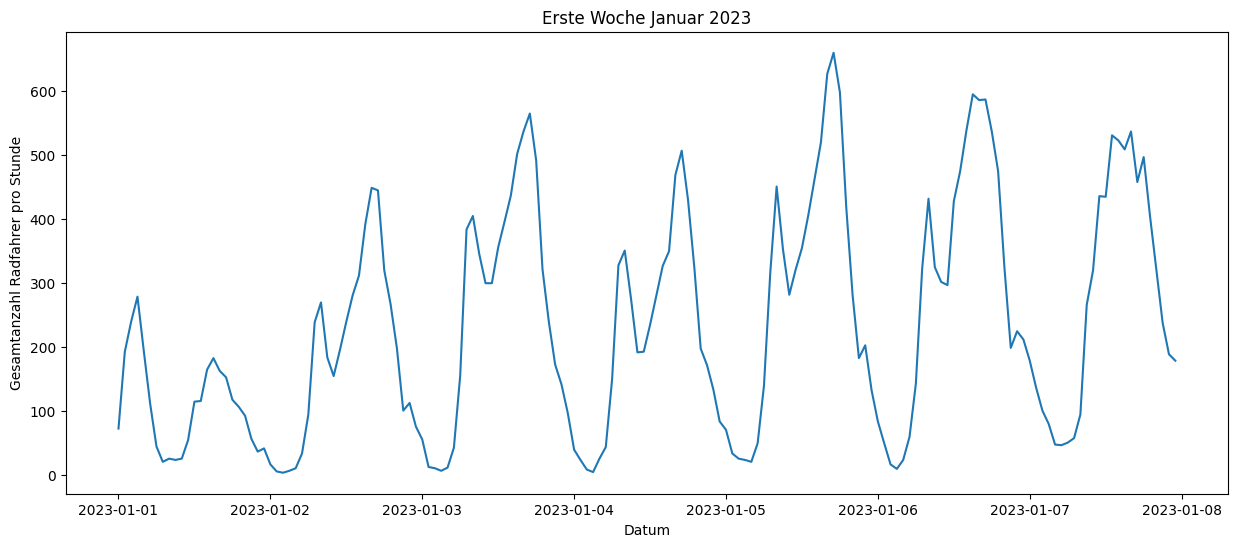

In [25]:
plt.figure(figsize=(15, 6))
plt.plot(df_plot['DatumZeit'], df_plot['Neutor (gesamt)'])
plt.title('Erste Woche Januar 2023')
plt.xlabel('Datum')
plt.ylabel('Gesamtanzahl Radfahrer pro Stunde')

plt.savefig("visualization/Januar_23.png", dpi=300, bbox_inches='tight')

plt.show()